# End - to - End Machine Learning Project

In [1]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
#Function that downloads the dataset from the author's github repo
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    
    #Check If directory datasets is not yet created
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    
    #download the dataset using the URL which will be saved to a path
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()

In [4]:
#Function to create a dataframe from reading the csv file
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

### Basic Information About the DataFrame

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
housing.shape

(20640, 10)

In [9]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

### Basic Plotting

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

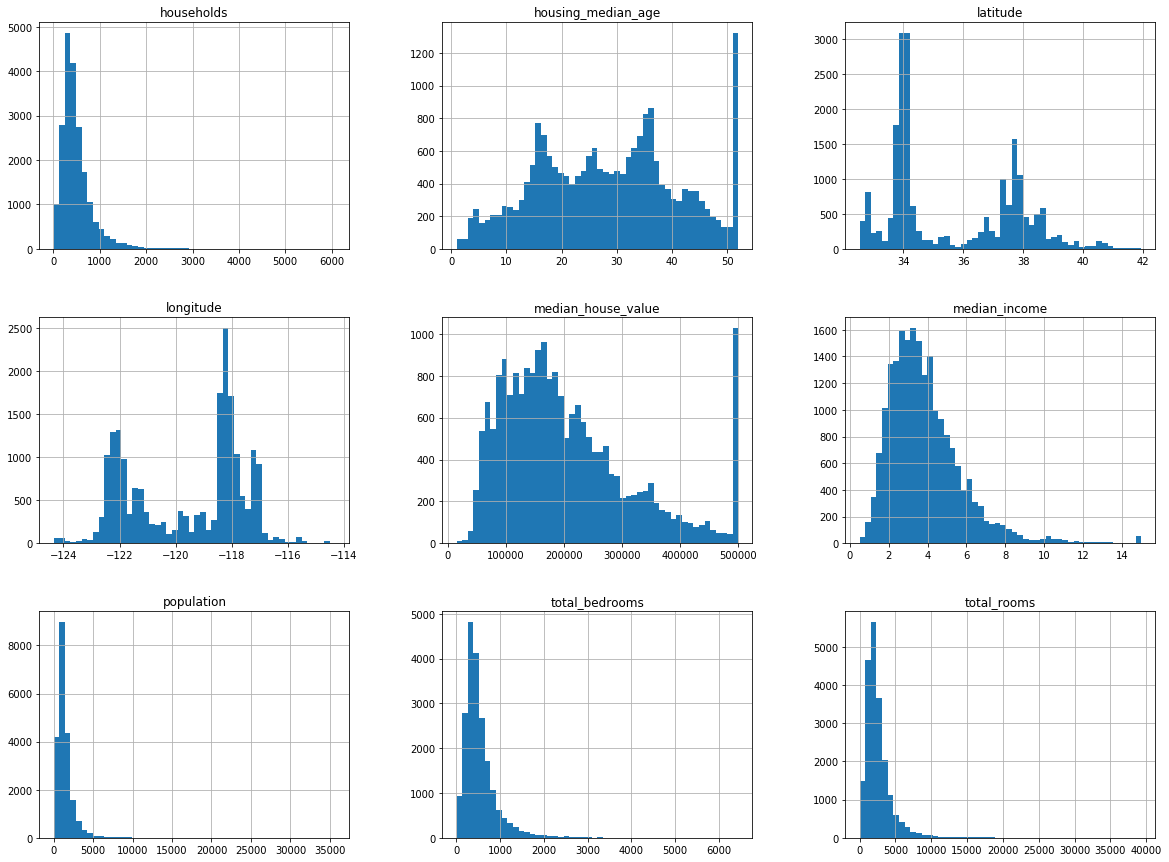

In [11]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

# Creating a Test

### Basic train-test-split

In [12]:
#Easiest way to create a train test split, but will result to overfit, due to shuffled_indices always changes every run,
#allowing the training model to see the data
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
split_train_test(housing, .2)[:2]

(       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 19888    -119.16     36.28                18.0       2377.0           414.0   
 7346     -118.14     33.97                36.0       1407.0           385.0   
 10221    -117.89     33.88                15.0       1655.0           626.0   
 20354    -118.97     34.18                18.0       7338.0          1020.0   
 7288     -118.22     33.98                42.0        626.0           143.0   
 16600    -120.69     35.65                14.0       3487.0           889.0   
 5903     -118.43     34.30                37.0       1394.0           313.0   
 16920    -122.33     37.57                43.0       2543.0           621.0   
 16838    -122.48     37.57                34.0       4648.0           806.0   
 13521    -117.41     34.24                20.0       1160.0           181.0   
 20417    -118.86     34.19                29.0       1326.0           185.0   
 6899     -118.13     34.04             

### Using hashing to identify test sets

>Using hashing we can identify the dataset, to ensure that we are not changing the train set everytime you run the functions

In [14]:
import hashlib

In [15]:
def test_set_check(identifier, test_ratio, hash):
    """
    @params:
    identifier: row id of the dataset
    test_ratio: percentage stated to be converted as test set
    hash: Hashing Algorithm
    """
    return hash(np.int64(identifier)).digest()[-1] < 256* test_ratio

In [16]:
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    """
    @params
    data: holds dataset
    test_ration: percentage of the dataset to be turned into test set
    id_column: part of the dataset the holds unique values for each row
    hash: type of hashing to use
    """
    ids = data[id_column]
    
    #Apply a lambda function that checks the data for the test set, then returns the data separated
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [17]:
housing_with_id = housing.reset_index()

In [18]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [19]:
train_set.head(10)

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY


### Creating a Test set using a more stable column

> Choosing which column to refernce your test set and training set is important. It ensures that when you needed to run the training algorithm again, you are properly and correctly choosing the correct training dataset and the correct test set

In [20]:
housing_with_id = housing.reset_index()

In [21]:
housing_with_id['id'] = housing['longitude']*1000+housing['latitude']

In [22]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [23]:
train_set[:10]

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,-122212.15
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,-122212.16
7,7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY,-122212.16
9,9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY,-122212.16
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY,-122232.15


### Creating test data using scikit learn train_test_split

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

In [26]:
train_set.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND
17848,-121.86,37.42,20.0,5032.0,808.0,2695.0,801.0,6.6227,264800.0,<1H OCEAN
6252,-117.97,34.04,28.0,1686.0,417.0,1355.0,388.0,2.5192,157300.0,<1H OCEAN
9389,-122.53,37.91,37.0,2524.0,398.0,999.0,417.0,7.9892,500001.0,NEAR BAY
6113,-117.90,34.13,5.0,1126.0,316.0,819.0,311.0,1.5000,139800.0,<1H OCEAN
6061,-117.79,34.02,5.0,18690.0,2862.0,9427.0,2777.0,6.4266,315600.0,<1H OCEAN


### Fixing the Data

>median income is mostly at around $5000$ - $6000$, and within 4 - 6

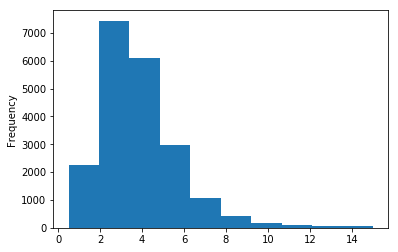

In [27]:
housing["median_income"].plot(kind='hist',)

In [28]:
housing["median_income"].head()

0    8.3252
1    8.3014
2    7.2574
3    5.6431
4    3.8462
Name: median_income, dtype: float64

In [29]:
#We are dividing the values of median_income by 1.5 then getting the ceiling value of that number is a float
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)

In [30]:
#Converting all values of income_cat that are greater than 5 to be 5.
#We are adding a ceiling to the unique values inside the income_cat column
housing["income_cat"].where(housing["income_cat"] < 5,5.0, inplace=True)

In [31]:
housing["income_cat"][:10]

0    5.0
1    5.0
2    5.0
3    4.0
4    3.0
5    3.0
6    3.0
7    3.0
8    2.0
9    3.0
Name: income_cat, dtype: float64

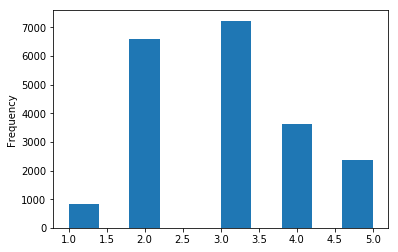

In [32]:
housing['income_cat'].plot(kind='hist')

### Sampling

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

In [34]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [35]:
strat_train_set.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3.0


In [36]:
strat_test_set.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,5.0
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN,4.0
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN,3.0
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND,3.0
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND,3.0


In [37]:
#We get the percentage of each income_cat values and know how much does the dataset consist of that.
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

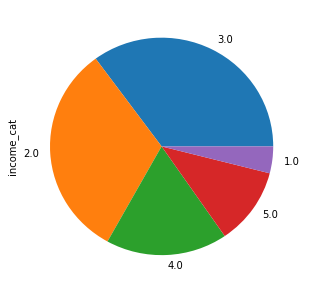

In [38]:
hs = housing['income_cat'].value_counts() / len(housing)
hs.plot(kind='pie',figsize=(5,5))

In [39]:
#Removing income_cat column
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Plotting the Data

In [40]:
housing = strat_train_set.copy()

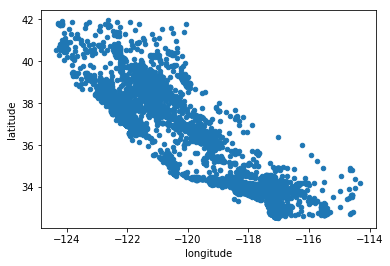

In [41]:
housing.plot(kind='scatter', x='longitude', y='latitude')

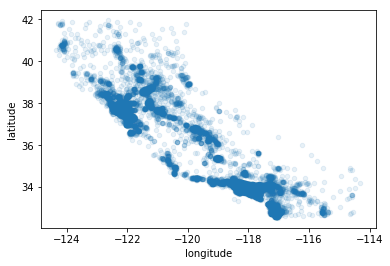

In [42]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

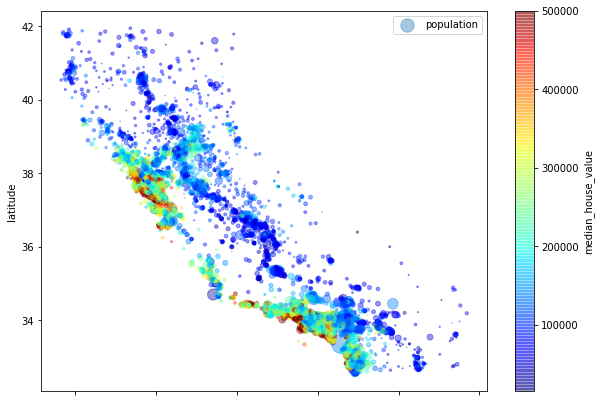

In [43]:
housing.plot(kind="scatter",
         x='longitude', 
            y='latitude',
            alpha=0.4,
            s=housing['population']/100, 
            label='population',
            figsize=(10,7),
            c="median_house_value",
            cmap=plt.get_cmap("jet"),
            colorbar=True
           )
plt.legend()

### Looking for correlations


In [44]:
corr_matrix = housing.corr()

In [45]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [46]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

### Another way to check for correlation

In [47]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4675ce9b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd46621fa90>]], dtype=object)

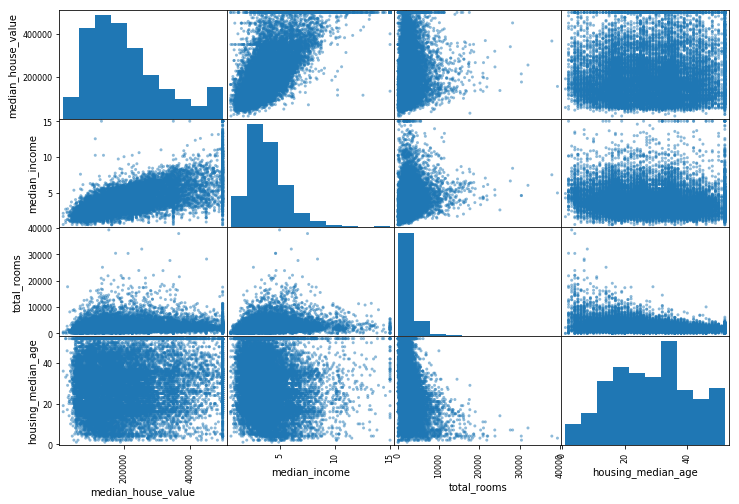

In [48]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

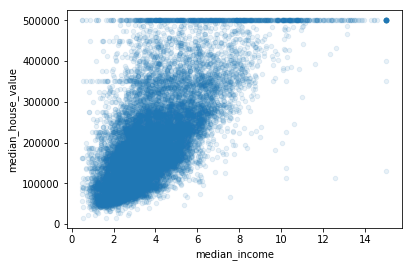

In [49]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [50]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing['bedroom_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [51]:
corr_matrix = housing.corr()

In [52]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedroom_per_room,population_per_household
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432,-0.028345,0.095603,-0.000410
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724,0.107621,-0.116884,0.005420
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110,-0.147186,0.136788,0.015031
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097,0.127519,-0.192606,-0.024810
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689,0.000377,0.086960,-0.028370
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920,-0.074692,0.037778,0.076225
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506,-0.083009,0.067162,-0.027416
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160,0.311563,-0.624674,0.021822
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000,0.146285,-0.259984,-0.021985
rooms_per_household,-0.028345,0.107621,-0.147186,0.127519,0.000377,-0.074692,-0.083009,0.311563,0.146285,1.000000,-0.398546,-0.005314


In [53]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedroom_per_room           -0.259984
Name: median_house_value, dtype: float64

### Preparing the Data for Machine Learning Algorithms

In [54]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [55]:
housing.dropna(subset=['total_bedrooms'])
#housing.drop('total_bedrooms', axis=1)
#median = housing['total_bedrooms'].median()
#housing['total_bedrooms'].fillna(median, inplace=True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,INLAND
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839,<1H OCEAN
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,INLAND
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,<1H OCEAN
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,<1H OCEAN


### Using Sklearns missing value class

In [56]:
from sklearn.preprocessing import Imputer

In [57]:
imputer = Imputer(strategy='median')

In [58]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [59]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [60]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [61]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [62]:
imputer.transform(housing_num)

array([[ -121.89  ,    37.29  ,    38.    , ...,   710.    ,   339.    ,
            2.7042],
       [ -121.93  ,    37.05  ,    14.    , ...,   306.    ,   113.    ,
            6.4214],
       [ -117.2   ,    32.77  ,    31.    , ...,   936.    ,   462.    ,
            2.8621],
       ..., 
       [ -116.4   ,    34.09  ,     9.    , ...,  2098.    ,   765.    ,
            3.2723],
       [ -118.01  ,    33.82  ,    31.    , ...,  1356.    ,   356.    ,
            4.0625],
       [ -122.45  ,    37.77  ,    52.    , ...,  1269.    ,   639.    ,
            3.575 ]])

In [63]:
x = imputer.transform(housing_num)

In [64]:
housing_tr = pd.DataFrame(x, columns=housing_num.columns)

In [65]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### Handling Text and Categorical Attributes

In [66]:
from sklearn.preprocessing import LabelEncoder

In [67]:
encoder = LabelEncoder()

In [68]:
housing_cat = housing['ocean_proximity']

#fit_transforms, calls the fit() function which runs the labelEncoder() and find the labels, then runs transform()
#which runs it on the dataset added and returns the manipulated (transformed) dataset
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [69]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


### One Hot Encode

In [70]:
from sklearn.preprocessing import OneHotEncoder

In [71]:
encoder = OneHotEncoder()

In [72]:
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [73]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

### LabelBinarizer

In [74]:
from sklearn.preprocessing import LabelBinarizer

In [75]:
encoder = LabelBinarizer()

In [76]:
housing_cat_1hot = encoder.fit_transform(housing_cat)

In [77]:
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### Custom Transformers

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin

In [79]:
rooms_ix, bedrooms_ix,population_ix, household_ix = 3,4,5,6

In [80]:
class CombinedAttributessAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X,y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix]/X[:, population_ix] 
        population_per_household = X[:, population_ix]  / X[:, household_ix] 
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributessAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform

In [81]:
#Let's see what is inside attr_adder and bousing_extra_atribs
housing_extra_attribs

<bound method CombinedAttributessAdder.transform of CombinedAttributessAdder(add_bedrooms_per_room=False)>

### Transformation Pipeline

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [83]:
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributessAdder()),
    ('std_scaler', StandardScaler())
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

### Wrong Code from the book but corrected by Author on his Github Page

In [84]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [85]:
#from sklearn.preprocessing import CategoricalEncoder # in future versions of Scikit-Learn

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [90]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [91]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [92]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)]

In [93]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [94]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [100]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [101]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [102]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [103]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

### Note:

Replicate and study the changes in the code, explanation's are currently only found in the repository.
For now continue with Training and Evaluating on Training Set

### Training and Evaluating on the Training Set

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)